# Robust High-Resolution Video Matting with Temporal Guidance.

![Teaser](https://raw.githubusercontent.com/PeterL1n/RobustVideoMatting/master/documentation/image/teaser.gif)

[Project Site](https://peterl1n.github.io/RobustVideoMatting) | [GitHub](https://github.com/PeterL1n/RobustVideoMatting) | [Paper](https://arxiv.org/abs/2108.11515)


## Colab Demo
This colab notebook is set up to let you quickly test our model on your video.

### Option 1: Upload your video

Run the cell below and upload your own video. (Only tested on .mp4 files)

In [9]:
import os
from google.colab import files

uploaded = files.upload()           # Use colab upload dialog.
uploaded = list(uploaded.keys())    # Get uploaded filenames.
assert len(uploaded) == 1           # Make sure only uploaded one file.
output_type = 'video'
img_dir = 'input.mp4'
output_dir = "com.mp4" 
out_alpha = "alpha.mp4"
out_frg = "frg.mp4"
os.rename(uploaded[0], img_dir) # Rename file to "input.mp4".

Saving driver (1).mp4 to driver (1).mp4


### Option 2: Try our demo video

Run the cell below to download our demo video. Skip it if you have uploaded your own video.

In [17]:
import os
from google.colab import files
!gdown https://drive.google.com/uc?id=1I0v72-hNlK1hm9q1OwyaATUYApXpotS6 -O input.mp4
img_dir= "input.mp4"
output_dir = "com.mp4"
out_alpha = "alpha.mp4"
out_frg = "frg.mp4"
output_type = 'video'

Downloading...
From: https://drive.google.com/uc?id=1I0v72-hNlK1hm9q1OwyaATUYApXpotS6
To: /content/input.mp4
100% 6.36M/6.36M [00:00<00:00, 41.0MB/s]


### Option 3: Upload your image
Run the cell below and upload your own image

In [1]:
# @title Select image sequence folder
import os
from google.colab import files
img_dir= "/content/img/" #@param 
output_dir = "/content/out/" #@param
output_type = 'png_sequence'
out_frg = '/content/foreground'
out_alpha = '/content/alpha'
os.makedirs(img_dir, exist_ok=True)
%cd {img_dir}
uploaded = files.upload()           # Use colab upload dialog.
uploaded = list(uploaded.keys())    # Get uploaded filenames.
os.rename(uploaded[0], 'img.png') # Rename file to 
%cd /content/

/content/img


Saving me vol.2.jpg to me vol.2.jpg
/content


### Start Inference

Run the cells below to process your video.

In [2]:
!pip install --quiet av pims
!pip install Pillow
!pip install matplotlib
from matplotlib import pyplot as plt
import numpy as np
import PIL

     |████████████████████████████████| 28.2 MB 91.7 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Download normal prediction model
!git clone https://github.com/boukhayma/face_normals.git
path_to_normal_model = '/content/face_normals/data/model.pth'
!gdown --id 1Qb7CZbM13Zpksa30ywjXEEHHDcVWHju_ -O {path_to_normal_model}

Cloning into 'face_normals'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 105 (delta 2), reused 1 (delta 1), pack-reused 102
Receiving objects: 100% (105/105), 234.05 KiB | 9.00 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qb7CZbM13Zpksa30ywjXEEHHDcVWHju_
To: /content/face_normals/data/model.pth
100% 143M/143M [00:00<00:00, 173MB/s]


In [15]:
import torch

model = torch.hub.load("PeterL1n/RobustVideoMatting", "mobilenetv3").cuda() # or "resnet50"
convert_video = torch.hub.load("PeterL1n/RobustVideoMatting", "converter")

Using cache found in /root/.cache/torch/hub/PeterL1n_RobustVideoMatting_master
Using cache found in /root/.cache/torch/hub/PeterL1n_RobustVideoMatting_master


In [19]:
convert_video(
    model,                           # The loaded model, can be on any device (cpu or cuda).
    input_source=img_dir,        # A video file or an image sequence directory.
    downsample_ratio=None,           # [Optional] If None, make downsampled max size be 512px.
    output_type=output_type,             # Choose "video" or "png_sequence"
    output_composition=output_dir ,    # File path if video; directory path if png sequence.
    output_alpha=out_alpha,          # [Optional] Output the raw alpha prediction.
    output_foreground=out_frg,     # [Optional] Output the raw foreground prediction/
    output_video_mbps=4,             # Output video mbps. Not needed for png sequence.
    seq_chunk=12,                    # Process n frames at once for better parallelism.
    num_workers=1,                   # Only for image sequence input. Reader threads.
    progress=True                    # Print conversion progress.
)

  0%|          | 0/353 [00:00<?, ?it/s]

In [20]:
# @title Visualise video results (Skip for Image Sequence Option 3)
from IPython.display import HTML
from base64 import b64encode
mp4 = open(output_dir,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

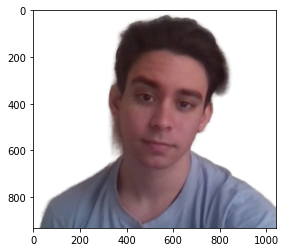

In [6]:
# @title Show image
from IPython.display import Image, display
for img in os.listdir(output_dir):
  if '.png' in img:
    fullpath = output_dir + img
    img = PIL.Image.open(fullpath)
    plt.imshow(img) 

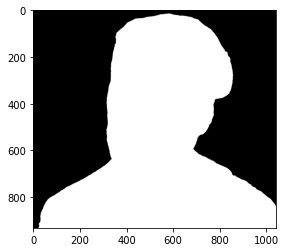

In [7]:
# @title Get face Mask
for img in os.listdir(output_dir):
  if '.png' in img:
    fullpath = output_dir +img 
    img  = PIL.Image.open(fullpath)
    img_np = np.array(img)
    img_np[img_np !=0] = 255
    mask = np.array(img_np, dtype=np.uint8)[:,:,0:3]
    plt.imshow(mask)
    PIL.Image.fromarray(mask).convert('RGB').save(output_dir + 'mask.png')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

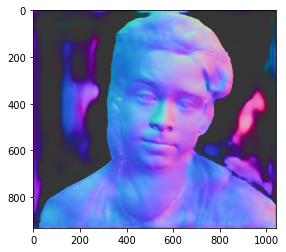

In [8]:
# @title Get Normal Map
# Remember that a Normal map stores the X, Y and Z values in the respective R, G and B channels
# If R is more prevelant it means that the face is closer in the X direction
# if G is more prevelant in the picture it means the face is closer to the Y direction
# if B is more prevelant, it means that the face is moving/is closer to the Z direction
import sys
sys.path.append('/content/face_normals/resnet_unet')
sys.path.append('/content/face_normals/')
import torch
from torch.autograd import Variable
import sys
from torchvision.transforms import Compose, ToTensor
from resnet_unet import ResNetUNet
import cv2
import numpy as np
from PIL import Image
from PIL import ImageOps
img_transform = Compose([
  ToTensor()
])

model_res = ResNetUNet(n_class = 3).cuda()
model_res.load_state_dict(torch.load(path_to_normal_model))
                                               
model_res.eval()

for img in os.listdir(output_dir):
  if ('.png' in img) and (not 'mask' in img) and (not 'normal' in img):
    fullpath = output_dir + img
    img = Image.open(fullpath).convert('RGB')
    h, w, c = np.array(img).shape
    m = max(h,w) # max dimension
    mult = int(m/256) # normal size closest to our max dimension
    #img = ImageOps.pad(img,(2*256, 2*256))
    img = img.resize((2*256, 2*256))
    img = img_transform(img).unsqueeze(0)
    img = Variable(img.cuda())
    
    outs = model_res(img)[0]  
    out = np.array(outs[0].data.permute(1,2,0).cpu())  
    out = out / np.expand_dims(np.sqrt(np.sum(out * out, 2)),2)
    out = 127.5 * (out + 1.0)
    out = np.array(out, dtype=np.uint8)
    out = PIL.Image.fromarray(out).convert('RGB')
    #out = ImageOps.pad(out,(w, h))
    out = out.resize((w, h)) # align again the results
    out = np.array(out, dtype=np.uint8)
    plt.imshow(out)
    PIL.Image.fromarray(out).convert('RGB').save(output_dir + 'normal.png')
    


### Download results

After the processing is done, you can download the results from the files panel on the left.

* `com.mp4`: The matting result composited on top of a green screen background.
* `alpha.mp4` or `alpha/`: The raw alpha matte.
* `fgr.mp4`or `foreground/`  : The raw foreground prediction.

or 
* `out/0000.png`: Matting result for a single image
* `out/mask.png`: Mask result for single image
* `out/normal.png`: Normal map for single image 